<a href="https://colab.research.google.com/github/manycoding/signatures-detection/blob/master/Signatures_detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U -q torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install -q cython pyyaml==5.1
!pip install -U -q 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

In [0]:
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

     |████████████████████████████████| 6.2MB 720kB/s 
     |████████████████████████████████| 61kB 5.0MB/s 


In [0]:
gpu = !nvidia-smi
gpu = 0.5 if "Tesla P4" in gpu[7] else 1
gpu

1

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import gc
import random
import os
import numpy as np
import pandas as pd
import torch
import json
from PIL import Image
from functools import partial
from pathlib import Path

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

root_dir = Path("/content/gdrive/My Drive/")
home = root_dir/"fastai/Signature/"
home.mkdir(parents=True, exist_ok=True)
data = home/"dataset"

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Data

In [0]:
raw_labels = pd.read_csv(data/"image_object_detection_1.csv",
                         names="set,image_path,label,x1,y1,x2,y1_,x2_,y2,x1_,y2_".split(","),
                         usecols=[0,1,2,8,3,4,5])[["set", "image_path", "label", "y2", "x1", "y1", "x2"]]
raw_labels["image_path"] = raw_labels["image_path"].apply(lambda x: data/"train"/x.split("/")[-1])

In [0]:
def process(f, labels):
    img = Image.open(f)
    labels.loc[labels["image_path"] == f, ["width"]] = img.size[0]
    labels.loc[labels["image_path"] == f, ["height"]] = img.size[1]
    labels.loc[labels["image_path"] == f, ["x1", "x2"]] = labels.loc[labels["image_path"] == f, ["x1", "x2"]] * img.size[0]
    labels.loc[labels["image_path"] == f, ["y2", "y1"]] = labels.loc[labels["image_path"] == f, ["y2", "y1"]] * img.size[1]

raw_labels["width"] = 0
raw_labels["height"] = 0

for f in raw_labels.image_path.unique():
    process(f, raw_labels)

In [0]:
raw_labels["bboxes"] = raw_labels[["x1", "y1", "x2", "y2"]].apply(lambda x: [x[0], x[1], x[2], x[3]], axis=1)

In [0]:
labels_df = pd.DataFrame()

for n, g in raw_labels.groupby("image_path"):
    labels_df = labels_df.append([[n, g["bboxes"].to_list(), g["label"].to_list(),
                                   g["width"].to_list()[0], g["height"].to_list()[0],
                                   g["set"].to_list()[0], g.index[0]]], ignore_index=True)

labels_df = labels_df.rename(columns={0: "image", 1: "bboxes", 2: "labels", 3: "width", 4: "height",
                                      5: "set", 6: "image_id",})

In [0]:
labels_df.head()

image  ... image_id
0  /content/gdrive/My Drive/fastai/Signature/data...  ...       25
1  /content/gdrive/My Drive/fastai/Signature/data...  ...       41
2  /content/gdrive/My Drive/fastai/Signature/data...  ...       44
3  /content/gdrive/My Drive/fastai/Signature/data...  ...       11
4  /content/gdrive/My Drive/fastai/Signature/data...  ...       39

[5 rows x 7 columns]

In [0]:
# !mkdir -p data/signatures/
# !ln -s "{data}/train" data/signatures/
# !ln -s "{data}/test" data/signatures/

In [0]:
from detectron2.structures import BoxMode

def create_labels(df, set="train"):
    labels_l = []
    if set == "train":
        _df = df[df.set == "TRAIN"]
    elif set == "test":
        return create_test_labels(data/"test")
    else:
        _df = df[df.set != "TRAIN"]
    for i, r in _df.iterrows():
        l = {"file_name": str(r["image"]),
             "width": r["width"],
             "height": r["height"],
             "image_id": r["image_id"],}
        annotations = []
        for bbox in r["bboxes"]:
            annotations.append({"category_id": 0,
                                "bbox": bbox,
                                "bbox_mode": BoxMode.XYXY_ABS,})
        l["annotations"] = annotations
        labels_l.append(l)
    return labels_l

In [0]:
create_labels(labels_df)[4]

{'annotations': [{'bbox': [577.06458, 572.474454, 690.841482, 608.1611727],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [271.4285736, 418.57549025, 446.18395019999997, 464.67082049999993],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}],
 'file_name': '/content/gdrive/My Drive/fastai/Signature/dataset/train/000006-2020-02-14T16:50:17.555Z.jpg',
 'height': 655,
 'image_id': 39,
 'width': 1140}

In [0]:
def create_test_labels(path):
    labels = []
    for i, f in enumerate(os.listdir(path)):
        img = Image.open(str(path/f))
        l = {"file_name": str(path/f),
             "width": img.size[0],
             "height": img.size[1],
             "image_id": i,}
        labels.append(l)
    return labels

In [0]:
DatasetCatalog.clear()

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "valid", "test"]:
    DatasetCatalog.register("sign_" + d, lambda d=d: create_labels(labels_df, set=d))
    MetadataCatalog.get("sign_" + d).set(thing_classes=["sign"])
sign_metadata = MetadataCatalog.get("sign_train")

In [0]:
MetadataCatalog.get("sign_train").thing_classes = ["sign"]

In [0]:
sign_metadata

Metadata(name='sign_train', thing_classes=['sign'])

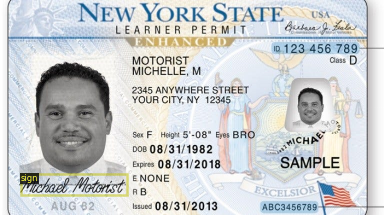

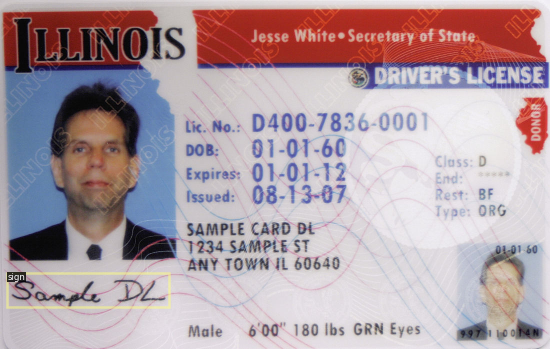

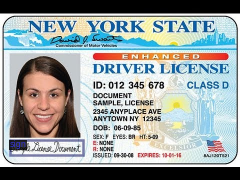

In [0]:
dataset_dicts = create_labels(labels_df, set="valid")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sign_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()

In [0]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sign_train",)
cfg.DATASETS.TEST = ("sign_valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (ballon)
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[x, x * 0.25, x * 0.1 ] for x in [32, 64, 128, 256, 512]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1]]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [0]:
[[x, x * 0.25, x * 0.1 ] for x in [32, 64, 128, 256, 512]]

[[32, 8.0, 3.2],
 [64, 16.0, 6.4],
 [128, 32.0, 12.8],
 [256, 64.0, 25.6],
 [512, 128.0, 51.2]]

In [0]:
[[x, x * 2**(1.0/3), x * 2**(2.0/3) ] for x in [32, 64, 128, 256, 512]]

[[32, 40.31747359663594, 50.79683366298238],
 [64, 80.63494719327188, 101.59366732596476],
 [128, 161.26989438654377, 203.18733465192952],
 [256, 322.53978877308754, 406.37466930385904],
 [512, 645.0795775461751, 812.7493386077181]]

In [0]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [0]:
from detectron2.evaluation.coco_evaluation import *
from detectron2.evaluation import *

In [0]:
# DefaultTrainer.test(evaluators=DatasetEvaluators([COCOEvaluator("sign_test", cfg, distributed=False)]))

In [0]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
cfg.MODEL.RETINANET.SCORE_THRESH_TEST

0.05

In [0]:
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.8
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

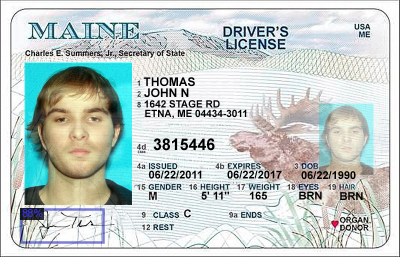

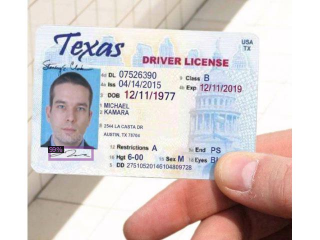

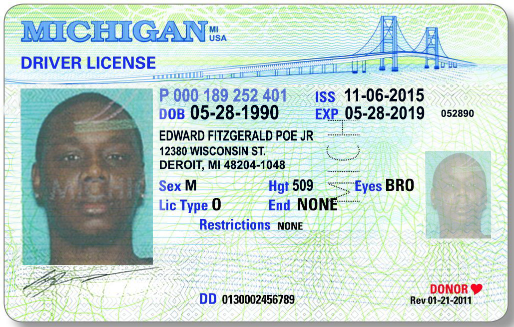

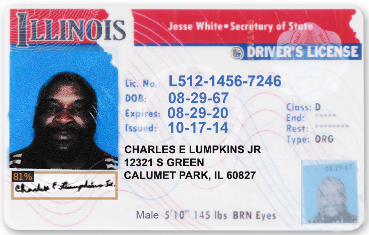

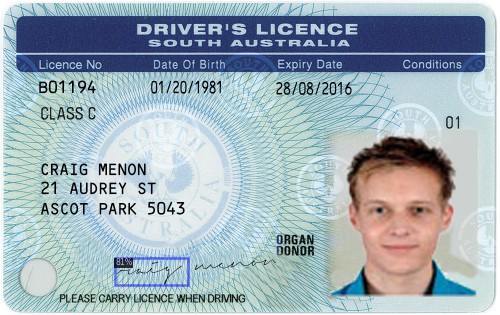

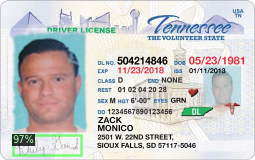

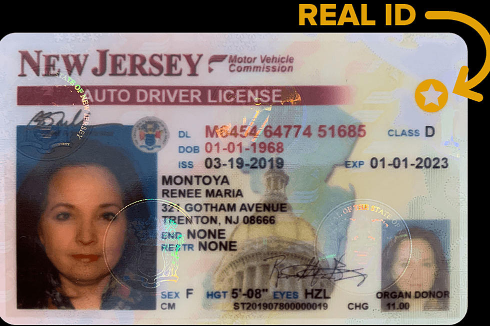

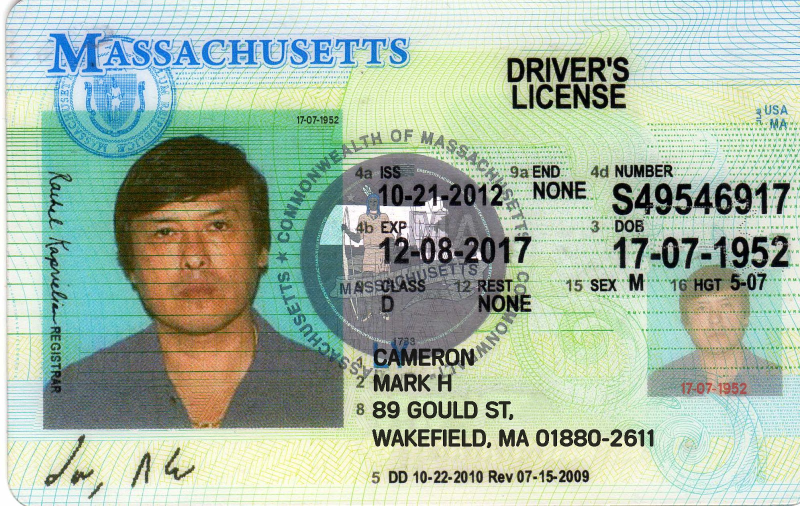

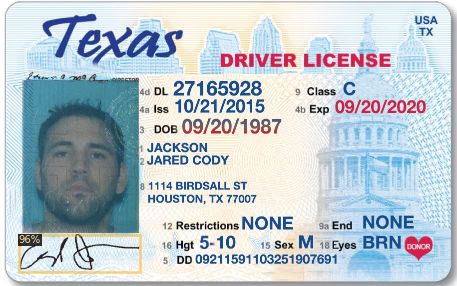

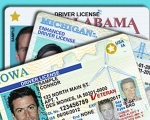

In [0]:
from detectron2.utils.visualizer import ColorMode
for d in create_labels(labels_df, set="test")[:10]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sign_metadata,
                   scale=0.5
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

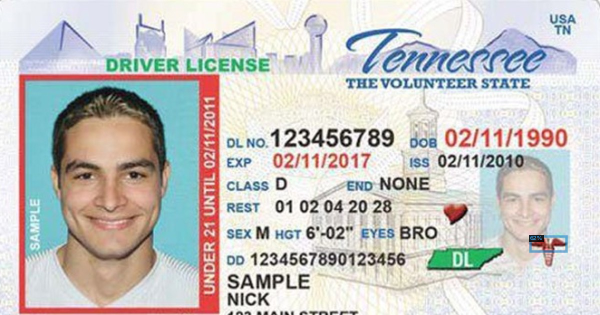

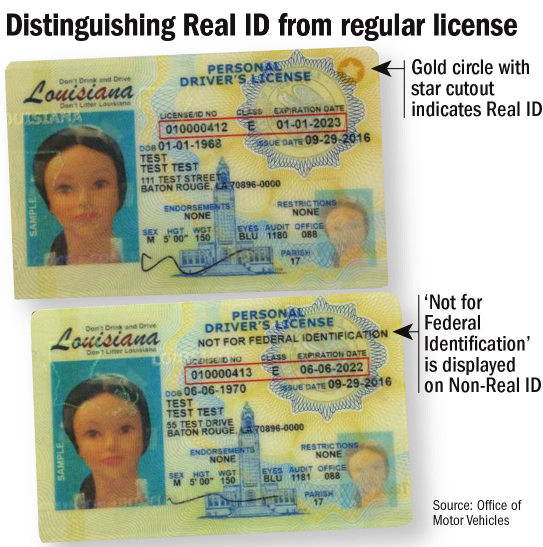

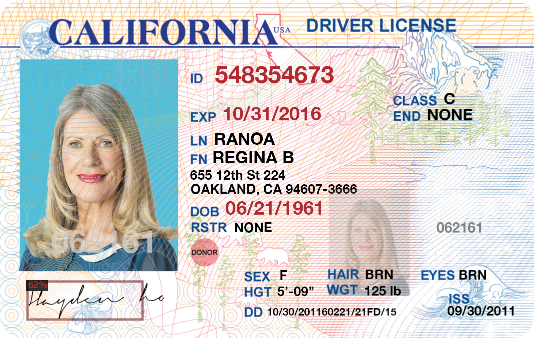

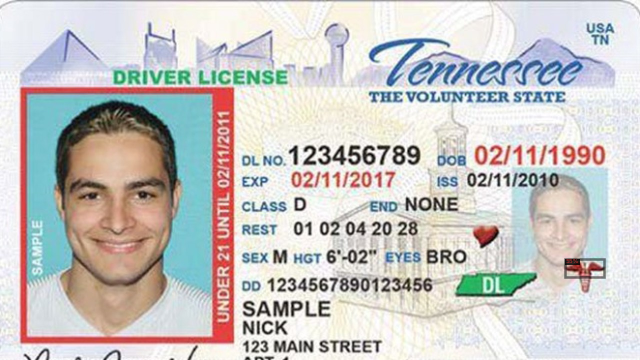

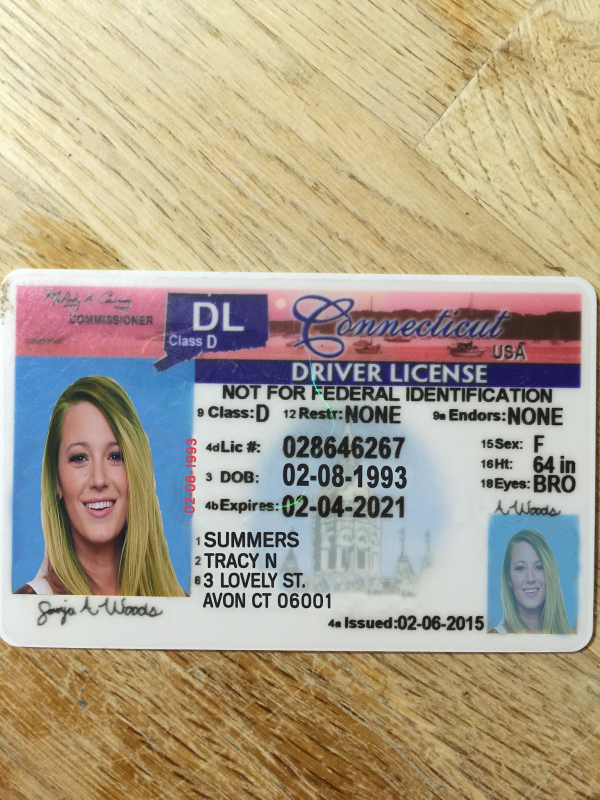

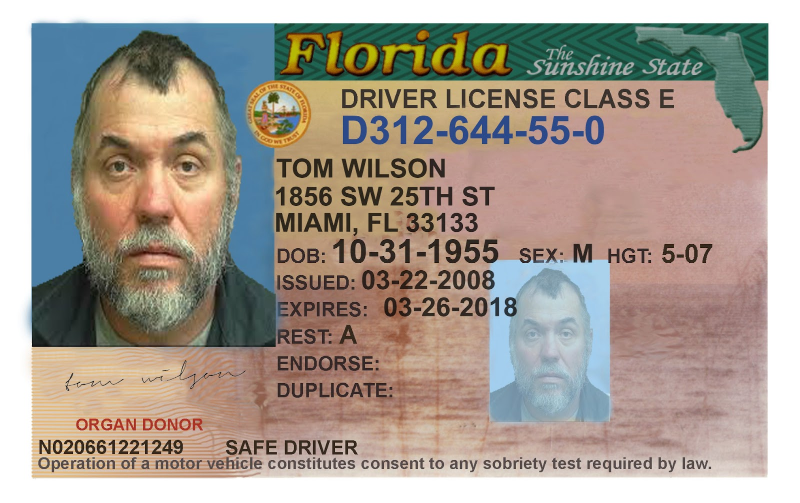

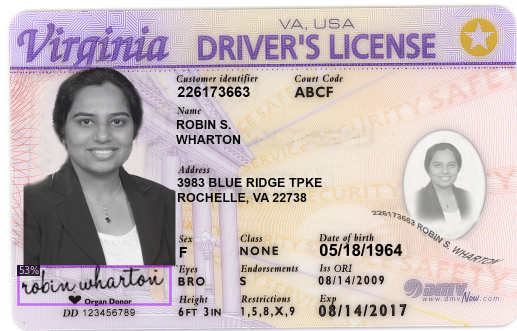

In [0]:
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

for d in create_labels(labels_df, set="test")[10:]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sign_metadata,
                   scale=0.5
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])